# GETTIN
## Planejamento de Equipamentos Escolares
## Método: k-Median
### Versão: 1.0
#### Fillipe O Feitosa <fillipefeitosa@ua.pt>

---


#### Modeling and Creating Decision Variables

\begin{split}& \mbox{minimize} \quad    & \sum_{i=1}^n \sum_{j=1}^m c_{ij} x_{ij} &     \\
& \mbox{subject to:} \quad & \sum_{j=1}^m x_{ij} =1 &  \mbox{ for } i=1,\cdots,n\\
&   & \sum_{j=1}^m y_{j} = k                        &   \\
&   & x_{ij} \leq y_j                               & \mbox{ for }  i=1,\cdots,n; j=1,\cdots,m  \\
&   & x_{ij} \in \{ 0,1 \}                          & \mbox{ for }  i=1,\cdots,n; j=1,\cdots,m \\
&   & y_j \in \{ 0,1 \}                             & \mbox{ for }  j=1,\cdots,m\end{split}

In [11]:
# Import Libraries
from gurobi import *
import math
import matplotlib.pyplot as plt

def distance(a,b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return math.sqrt(dx*dx + dy*dy)

# Data
# Problem data


# ---------- K - MEDIAN ------------#

k = 11

# subSections = [[0, 1.5],[1.5, 0.5],[0.75, 1.5],[1.2, 0.5],[1.7, 0.1],[0.87, 1.5],[1.42, 1.5]]
# schools = [[1,0],[1,1],[1,2],
#           [2,0],[2,1],[2,2]]

import geopandas as gpd

vagos = gpd.read_file('./data_gettin/vagos.geojson');
centroids = vagos.centroid

iteratorHandler = centroids.size
centroidVector = []
for centroid in centroids:
    obj = [centroid.xy[0][0], centroid.xy[1][0]]
    centroidVector.append(obj)

subSections = centroidVector
schools = centroidVector
# @charge: custo de construcao por escola (fixo em 500 mil euros)
# charge = 5000000

numSchools = len(schools)
numSubSections = len(subSections)

# Creting Guroby Model
m = Model()

# Decision Variables
x = {}
y = {}
d = {} # Distance Matrix
# @alpha: 0.29 de custo por Km  por (365 dias * 5 anos) 
alpha = 529.25

# creating binary variable for every school
for j in range(numSchools):
    x[j] = m.addVar(obj=0, vtype=GRB.BINARY, name="escola(%d)" % j)

# creating continuous variable for subsections to check suply fractions
for i in range(numSubSections):
    for j in range(numSchools):
        # Distances between Subsections and Schools
        d[(i,j)] = distance(subSections[i], schools[j])
        # Fractions of Subsection Suply
        y[(i,j)] = m.addVar(obj=d[i,j], vtype=GRB.BINARY, name="Demanda de Sub[%d] atendida pela escola[%d]" % (i,j))
        
m.update()

Academic license - for non-commercial use only


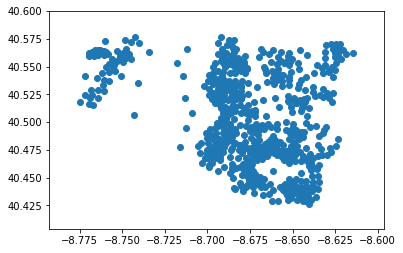

In [12]:
plt.scatter(*zip(*subSections))
plt.show()

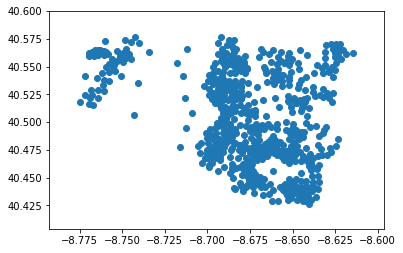

In [13]:
plt.scatter(*zip(*schools))
plt.show()

## Adding Constraints

In [14]:
# Constraint for Every Student on School
# for i in range(numSubSections):
#     m.addConstr(quicksum(y[(i,j)] for j in range(numSchools)) == 1)
for i in range(numSubSections):
    coef = [1 for j in range(numSchools)]
    var = [y[i,j] for j in range(numSchools)]
    m.addConstr(LinExpr(coef,var), "=", 1, name="Assign[%s]"%i)

# Constraint to set number of Schools equal to K
# m.addConstr(quicksum(x) == k)

coef = [1 for j in range(numSchools)]
var = [x[j] for j in range(numSchools)]
m.addConstr(LinExpr(coef,var), "=", rhs=k, name="k_median") 


# Fraction of suply must be lower or equal than the BINARY x[j] available 
# for i in range(numSubSections):
#     for j in range(numSchools):
#         m.addConstr(y[(i,j)] <= x[j])

for j in range(numSchools):
    for i in range(numSubSections):
        m.addConstr(y[i,j], "<", x[j], name="Strong[%s,%s]"%(i,j))

# THIS IS THE WRONG WAY TO ITERATE. DONT DO IT.
# for i in range(numSubSections):
#     for j in range(numSchools):
#         m.addConstr(quicksum(y[(i,j)]) <= x[j])


# Constraint to improve linear relaxation - RIGHT WAY!!!
# for j in range(numSchools):
#     m.addConstr(quicksum(y[(i,j)] for i in range(numSubSections)) <= x[j])

#### Objetive


In [15]:
# Setting objective

m.setObjective( 
    quicksum(d[i,j]*y[i,j] for i in range(numSubSections) for j in range(numSchools)), GRB.MINIMIZE )

m.optimize()

Optimize a model with 480943 rows, 480942 columns and 1441440 nonzeros
Variable types: 0 continuous, 480942 integer (480942 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-04, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve time: 8.20s
Presolved: 480943 rows, 480942 columns, 1441440 nonzeros
Variable types: 0 continuous, 480942 integer (480942 binary)
Found heuristic solution: objective 22.3863401

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2386340e+01   0.000000e+00   3.814831e+03     14s
   48170    1.9381702e+01   0.000000e+00   1.333582e+03     15s
   95560    1.2047963e+01   0.000000e+00   2.440192e+03     20s
  101336    1.1867957e+01   0.000000e+00   3.394662e+03     25s
  107112    1.1560723e+01 

In [16]:
m

<gurobi.Model MIP instance Unnamed: 480943 constrs, 480942 vars, Parameter changes: CSIdleTimeout=1800>

In [17]:
print('Obj: %g' % m.objVal)

Obj: 7.69108


In [18]:
for v in m.getVars():
    if(v.x != 0):
       print('%s   %g' % (v.varName, v.x))

escola(15)   1
escola(49)   1
escola(83)   1
escola(119)   1
escola(302)   1
escola(327)   1
escola(392)   1
escola(426)   1
escola(440)   1
escola(589)   1
escola(643)   1
Demanda de Sub[0] atendida pela escola[589]   1
Demanda de Sub[1] atendida pela escola[643]   1
Demanda de Sub[2] atendida pela escola[440]   1
Demanda de Sub[3] atendida pela escola[440]   1
Demanda de Sub[4] atendida pela escola[440]   1
Demanda de Sub[5] atendida pela escola[440]   1
Demanda de Sub[6] atendida pela escola[440]   1
Demanda de Sub[7] atendida pela escola[440]   1
Demanda de Sub[8] atendida pela escola[440]   1
Demanda de Sub[9] atendida pela escola[327]   1
Demanda de Sub[10] atendida pela escola[15]   1
Demanda de Sub[11] atendida pela escola[15]   1
Demanda de Sub[12] atendida pela escola[15]   1
Demanda de Sub[13] atendida pela escola[15]   1
Demanda de Sub[14] atendida pela escola[15]   1
Demanda de Sub[15] atendida pela escola[15]   1
Demanda de Sub[16] atendida pela escola[15]   1
Demanda de 

Demanda de Sub[585] atendida pela escola[589]   1
Demanda de Sub[586] atendida pela escola[643]   1
Demanda de Sub[587] atendida pela escola[589]   1
Demanda de Sub[588] atendida pela escola[589]   1
Demanda de Sub[589] atendida pela escola[589]   1
Demanda de Sub[590] atendida pela escola[589]   1
Demanda de Sub[591] atendida pela escola[643]   1
Demanda de Sub[592] atendida pela escola[589]   1
Demanda de Sub[593] atendida pela escola[589]   1
Demanda de Sub[594] atendida pela escola[589]   1
Demanda de Sub[595] atendida pela escola[589]   1
Demanda de Sub[596] atendida pela escola[643]   1
Demanda de Sub[597] atendida pela escola[589]   1
Demanda de Sub[598] atendida pela escola[589]   1
Demanda de Sub[599] atendida pela escola[589]   1
Demanda de Sub[600] atendida pela escola[643]   1
Demanda de Sub[601] atendida pela escola[589]   1
Demanda de Sub[602] atendida pela escola[589]   1
Demanda de Sub[603] atendida pela escola[643]   1
Demanda de Sub[604] atendida pela escola[589]   1


In [19]:
m = None

In [20]:
disposeDefaultEnv()